In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from joblib import load

In [2]:
data_bs1 = pd.read_csv('../data/preprocessed_data_BS1.csv')
data_bs1.head()

,hg38_ASF1A,hg38_CCT7,hg38_EPOR,hg38_NECAP2,hg38_LRRC8A,hg38_NDUFS8,hg38_MRPL22,hg38_HIST1H2BC,hg38_LY96,hg38_UBE2E2-AS1,...,hg38_ASPSCR1,hg38_CDC20,hg38_DNAJB9,hg38_OSTM1,hg38_LCNL1,hg38_PHB,hg38_LRRC29,hg38_ZFP36,Group,Subgroups
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,B,Bmemory
1,0,0,0,3,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,B,Bmemory
2,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,2,0,3,B,Bmemory
3,0,0,0,0,0,3,0,0,0,0,...,0,0,3,0,0,3,0,0,B,Bmemory
4,0,0,0,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,B,Bmemory


In [3]:
X = data_bs1.drop(['Group', 'Subgroups'], axis=1)
y = data_bs1['Group']

In [4]:
y.unique()

array(['B', 'D', 'M', 'NK', 'T'], dtype=object)

In [5]:
def replace_values(y):
    return y.replace({'B': 0, 'M': 1, 'NK': 2, 'T': 3, 'D': 4}, regex=True)

In [6]:
encoded_y = replace_values(y)
encoded_y[:5], y[:5]

(0    0
 1    0
 2    0
 3    0
 4    0
 Name: Group, dtype: int64,
 0    B
 1    B
 2    B
 3    B
 4    B
 Name: Group, dtype: object)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, encoded_y, test_size=0.3, random_state=55)

In [8]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [9]:
def model_info(y_real, y_pred):
    cm = confusion_matrix(y_real, y_pred)
    class_sums = cm.sum(axis=1)
    normalized_conf_matrix = cm / class_sums[:, np.newaxis]
    labels = ['B', 'M', 'NK', 'T', 'D']
    sns.heatmap(normalized_conf_matrix, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels, fmt='.2f')
    plt.xlabel('Predvidjene vrednosti')
    plt.ylabel('Tacne vrednosti')
    plt.title('Matrica konfuzije')
    plt.show()

    print('Matrica konfuzije: \n', cm)
    print('Accuracy score: ', accuracy_score(y_real, y_pred))
    print('Precision score: ', precision_score(y_real, y_pred, average='weighted', zero_division=0))
    print('Recall score: ', recall_score(y_real, y_pred, average='weighted'))
    print('F1 score: ', f1_score(y_real, y_pred, average='weighted'))

In [10]:
def build_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    model_info(y_test, y_pred)

    return model

In [11]:
from xgboost import XGBClassifier

model_bs1 = XGBClassifier(random_state=55)

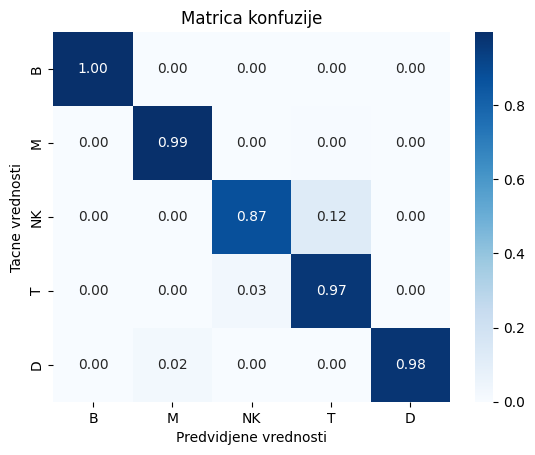

Matrica konfuzije: 
 [[ 516    1    0    1    0]
 [   0  493    0    2    1]
 [   1    0  342   49    0]
 [   1    1   80 2426    0]
 [   0    1    0    0   40]]
Accuracy score:  0.9651074589127686
Precision score:  0.966386261400732
Recall score:  0.9651074589127686
F1 score:  0.9656112385929325


In [12]:
model_bs1 = build_model(model_bs1, X_train, X_test, y_train, y_test)

In [13]:
# from sklearn.model_selection import GridSearchCV

# params = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 4, 5],
#     'learning_rate': [0.01, 0.1, 0.2]
# }

# model = XGBClassifier(random_state=55)
# grid_search = GridSearchCV(estimator=model, param_grid=params, scoring='accuracy', cv=3, verbose=1)

# grid_search.fit(X_train, y_train)

# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# best_model = XGBClassifier(**best_params, random_state=55)
# best_model.fit(X_train, y_train)

In [14]:
# best_params, best_score

In [15]:
best_model = model_bs1

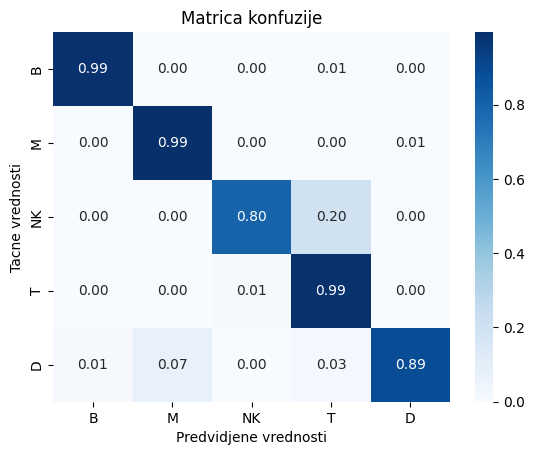

Matrica konfuzije: 
 [[ 585    0    0    6    0]
 [   0  593    0    0    3]
 [   0    0  216   54    0]
 [   1    2   26 2078    0]
 [   1    6    0    2   71]]
Accuracy score:  0.9722832052689352
Precision score:  0.9716678085018201
Recall score:  0.9722832052689352
F1 score:  0.971718350494811

--------------------------------------



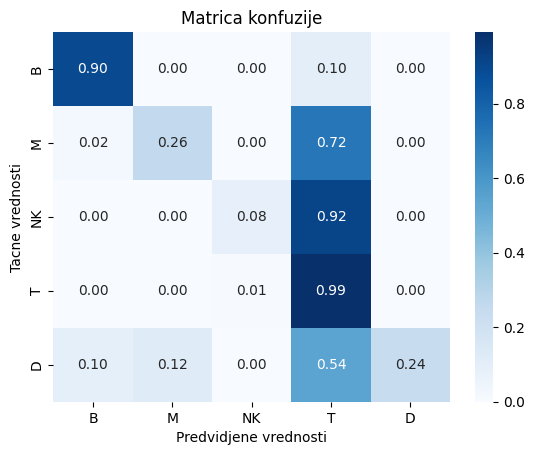

Matrica konfuzije: 
 [[1681    0    0  196    0]
 [  39  525    0 1442    0]
 [   0    0   71  771    0]
 [  17    2   41 7091    0]
 [  26   33    0  147   64]]
Accuracy score:  0.7765519512596739
Precision score:  0.8011207646893466
Recall score:  0.7765519512596739
F1 score:  0.726218758026274


In [16]:
data_bs2 = pd.read_csv('../data/preprocessed_data_BS2.csv')

X = data_bs2.drop(['Group', 'Subgroups'], axis=1)
y = data_bs2['Group']
encoded_y = replace_values(y)

X_train_bs2, X_test_bs2, y_train_bs2, y_test_bs2 = train_test_split(X, encoded_y, test_size=0.3, random_state=55)

model_bs2 = XGBClassifier(random_state=55)
model_bs2 = build_model(model_bs2, X_train_bs2, X_test_bs2, y_train_bs2, y_test_bs2)
print('\n--------------------------------------\n')

X_test_data = data_bs2.drop(['Group', 'Subgroups'], axis=1)
y_test_data = data_bs2['Group']
encoded_y_test_data = replace_values(y_test_data)

y_pred = best_model.predict(X_test_data)
model_info(encoded_y_test_data, y_pred)

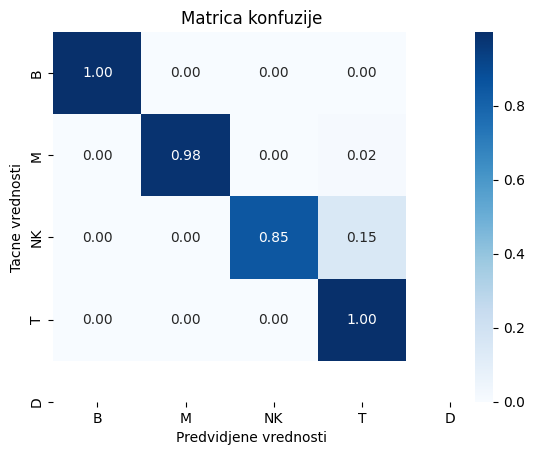

Matrica konfuzije: 
 [[ 515    0    0    1]
 [   0  259    0    4]
 [   0    0   67   12]
 [   1    3    0 4060]]
Accuracy score:  0.9957334416903698
Precision score:  0.9957421284320858
Recall score:  0.9957334416903698
F1 score:  0.9956353006156735

--------------------------------------



C:\Users\bogda\AppData\Local\Temp\ipykernel_17672\3007427038.py:4: RuntimeWarning: invalid value encountered in divide
  normalized_conf_matrix = cm / class_sums[:, np.newaxis]


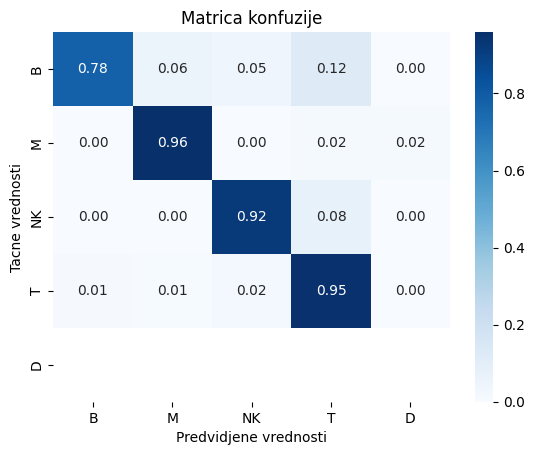

Matrica konfuzije: 
 [[ 1363   101    80   211     1]
 [    3   821     2    15    15]
 [    0     0   285    24     0]
 [  192   109   304 12868    11]
 [    0     0     0     0     0]]
Accuracy score:  0.9348978969826273
Precision score:  0.9494747025921002
Recall score:  0.9348978969826273
F1 score:  0.9395953833415543


C:\Users\bogda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
data_geo = pd.read_csv('../data/preprocessed_data_GEO.csv')

X = data_geo.drop(['Group', 'Subgroups'], axis=1)
y = data_geo['Group']
encoded_y = replace_values(y)

X_train_geo, X_test_geo, y_train_geo, y_test_geo = train_test_split(X, encoded_y, test_size=0.3, random_state=55)

model_geo = XGBClassifier(random_state=55)
model_geo = build_model(model_geo, X_train_geo, X_test_geo, y_train_geo, y_test_geo)
print('\n--------------------------------------\n')

X_test_data = data_geo.drop(['Group', 'Subgroups'], axis=1)
y_test_data = data_geo['Group']
encoded_y_test_data = replace_values(y_test_data)

y_pred = best_model.predict(X_test_data)
model_info(encoded_y_test_data, y_pred)

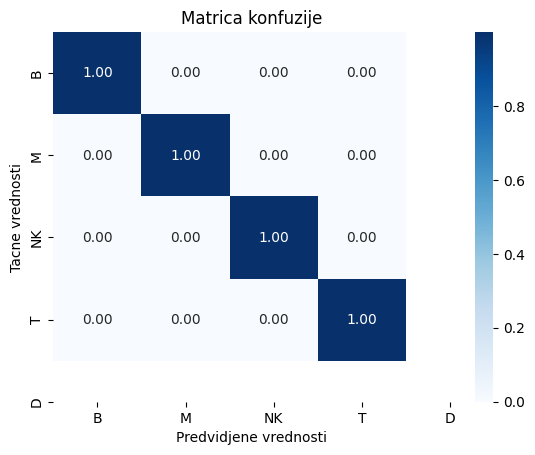

Matrica konfuzije: 
 [[ 2950     0     0     1]
 [    1   535     0     1]
 [    0     1  2408     8]
 [    3     0     5 18816]]
Accuracy score:  0.9991912329653443
Precision score:  0.9991910295822604
Recall score:  0.9991912329653443
F1 score:  0.9991910127035707

--------------------------------------



C:\Users\bogda\AppData\Local\Temp\ipykernel_17672\3007427038.py:4: RuntimeWarning: invalid value encountered in divide
  normalized_conf_matrix = cm / class_sums[:, np.newaxis]


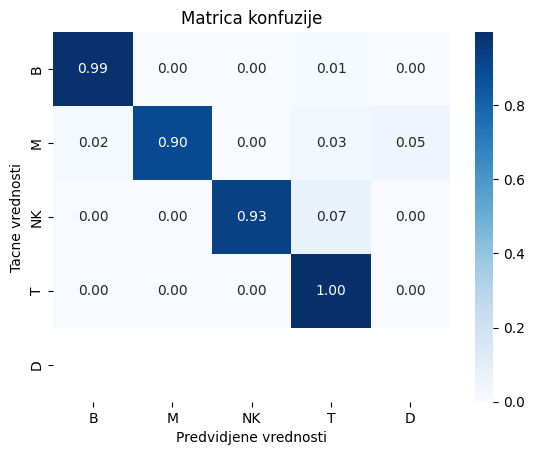

Matrica konfuzije: 
 [[ 9647     0     0    78     0]
 [   30  1660     3    63    92]
 [    0     0  7605   574     0]
 [   47     8   102 62511     8]
 [    0     0     0     0     0]]
Accuracy score:  0.9878075411268016
Precision score:  0.9890081205892475
Recall score:  0.9878075411268016
F1 score:  0.9882549614820992


C:\Users\bogda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
data_10x = pd.read_csv('../data/preprocessed_data_10x.csv')

X = data_10x.drop(['Group', 'Subgroups'], axis=1)
y = data_10x['Group']
encoded_y = replace_values(y)

X_train_10x, X_test_10x, y_train_10x, y_test_10x = train_test_split(X, encoded_y, test_size=0.3, random_state=55)

model_10x = XGBClassifier(random_state=55)
model_10x = build_model(model_10x, X_train_10x, X_test_10x, y_train_10x, y_test_10x)
print('\n--------------------------------------\n')

X_test_data = data_10x.drop(['Group', 'Subgroups'], axis=1)
y_test_data = data_10x['Group']
encoded_y_test_data = replace_values(y_test_data)

y_pred = best_model.predict(X_test_data)
model_info(encoded_y_test_data, y_pred)